In [5]:
from pandas import read_csv, Series
from gensim.models import Word2Vec
import numpy as np

In [6]:
from pymorphy2 import MorphAnalyzer
from nltk.tokenize import RegexpTokenizer
morph = MorphAnalyzer()
alpha_tokenizer = RegexpTokenizer('[A-Za-zА-Яа-я]\w+')

In [7]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.dummy import DummyClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import (accuracy_score, brier_score_loss, precision_score, recall_score, f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [8]:
import matplotlib.pyplot as plt
import seaborn

In [22]:
df = read_csv('2ch_test_set.csv')
df.head()

,index,text,is_relevent
0,0,ПХП умерло в 2013 году. Если свой сайт сделаю ...,1
1,1,"PHP это ковырялки легаси, плохая производитель...",1
2,2,"Не позорь go сообщество, чушь несешь.",1
3,3,После установки git появились git cmd и git ba...,1
4,4,даров где можно скачать какие нибудь паки карт...,0


In [23]:
Y = df.is_relevent.values

In [13]:
BOARD = 'b'

model = Word2Vec.load('models/' + BOARD + '_word2vec')
vocab = model.wv.vocab

In [14]:
def pre_process(sentence):
    sentence = sentence.lower()
    tokens = alpha_tokenizer.tokenize(sentence)
    model_tokens = []
    for index, word in enumerate(tokens):
        lem_word = morph.parse(word.lower())[0].normal_form
        if lem_word in vocab:
            model_tokens.append(lem_word)
    return model_tokens

In [15]:
old_err_state = np.seterr(all='raise')

def vectorize_message(sentence, model, num_features, vocab):
    featureVec = np.zeros((num_features), dtype='float32')
    nwords = 0
    
    tokens = pre_process(sentence.lower())

    for word in tokens:
        if word in vocab: 
            featureVec = np.add(featureVec, model[word])
            nwords = nwords + 1
    try:
        featureVec = np.divide(featureVec, nwords)
    except FloatingPointError:
         featureVec = np.zeros((num_features), dtype='float32')
    return featureVec

In [18]:
vec = []

for i in df.text.values:
    vec.append(vectorize_message(i, model, 100, vocab))

In [25]:
CHUNK = 40

X = np.array(vec)
Y = np.array(df.is_relevent.values)
X_train = X[:~CHUNK]
y_train = Y[:~CHUNK]
X_test = X[~CHUNK:]
y_test = Y[~CHUNK:]

In [26]:
X_test.shape

(41, 100)

In [30]:
clf = RandomForestClassifier(n_estimators = 150)
clf = clf.fit(X_train, y_train)
result = clf.predict(X_test)
accuracy_score(y_test, result)

0.58536585365853655

In [31]:
clf = SVC(C = 0.01, kernel = 'linear')
clf = clf.fit(X_train, y_train)
result = clf.predict(X_test)
accuracy_score(y_test, result)

0.53658536585365857

In [33]:
clf.predict(np.array(vectorize_message('питон + генсим = годнота!', model, 100, vocab)).reshape(1,-1))

array([1])

In [34]:
clf.predict(np.array(vectorize_message('пошёл нахуй зелёный веб макакер', model, 100, vocab)).reshape(1,-1))

array([1])

Comparsion

Logistic Regression:
	Brier: 0.252
	Precision: 0.537
	Recall: 1.000
	F1: 0.698

Naive Bayes:
	Brier: 0.486
	Precision: 0.564
	Recall: 1.000
	F1: 0.721

Random Forest:
	Brier: 0.348
	Precision: 0.586
	Recall: 0.773
	F1: 0.667

Support Vector Machine:
	Brier: 0.241
	Precision: 0.537
	Recall: 1.000
	F1: 0.698

KNN:
	Brier: 0.374
	Precision: 0.583
	Recall: 0.636
	F1: 0.609

Constant Classifier:
	Brier: 0.537
	Precision: 0.537
	Recall: 1.000
	F1: 0.698



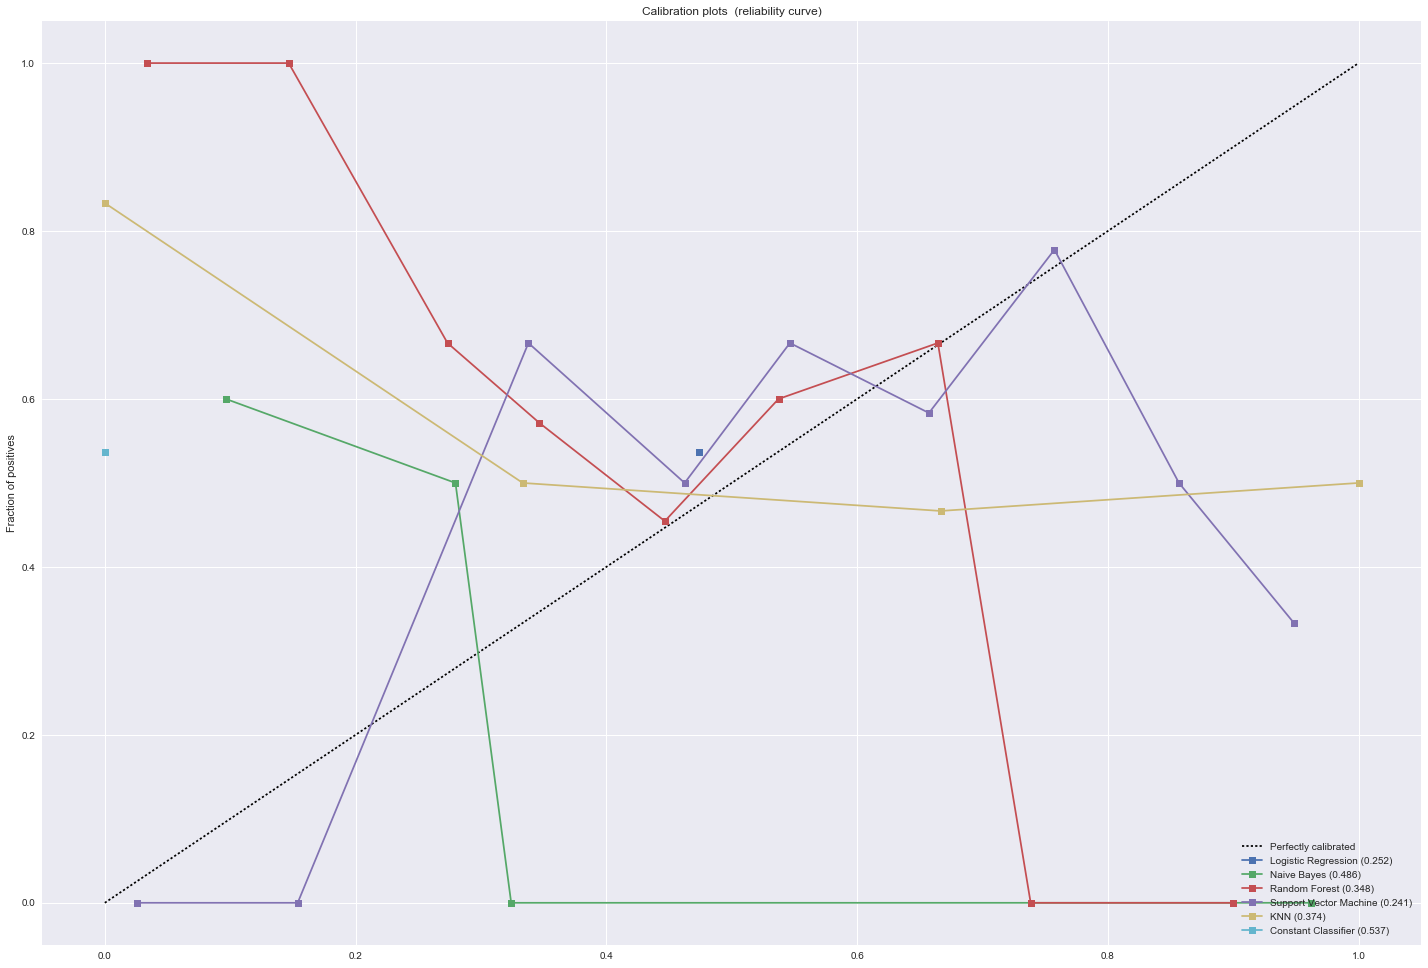

In [40]:
fig = plt.figure(figsize=(20, 20))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)

ax1.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
for clf, name in [(LogisticRegression(C=0.05, solver='lbfgs'), 'Logistic Regression'),
                  (BernoulliNB(), 'Naive Bayes'),
                  (RandomForestClassifier(n_estimators = 150), 'Random Forest'),
                  (SVC(C = 0.01, kernel = 'linear'), 'Support Vector Machine'),
                  (KNeighborsClassifier(n_neighbors = 3), 'KNN'),
                  (DummyClassifier(strategy = 'constant', constant = 1), 'Constant Classifier')
                 ]:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    if hasattr(clf, 'predict_proba'):
        prob_pos = clf.predict_proba(X_test)[:, 0]
    else: 
        prob_pos = clf.decision_function(X_test)
        prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

    clf_score = brier_score_loss(y_test, prob_pos, pos_label=y_test.max())
    print('%s:' % name)
    print('\tBrier: %1.3f' % (clf_score))
    print('\tPrecision: %1.3f' % precision_score(y_test, y_pred))
    print('\tRecall: %1.3f' % recall_score(y_test, y_pred))
    print('\tF1: %1.3f\n' % f1_score(y_test, y_pred))

    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, 's-',
             label='%s (%1.3f)' % (name, clf_score))

ax1.set_ylabel('Fraction of positives')
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc='lower right')
ax1.set_title('Calibration plots  (reliability curve)')

plt.tight_layout()


plt.show()

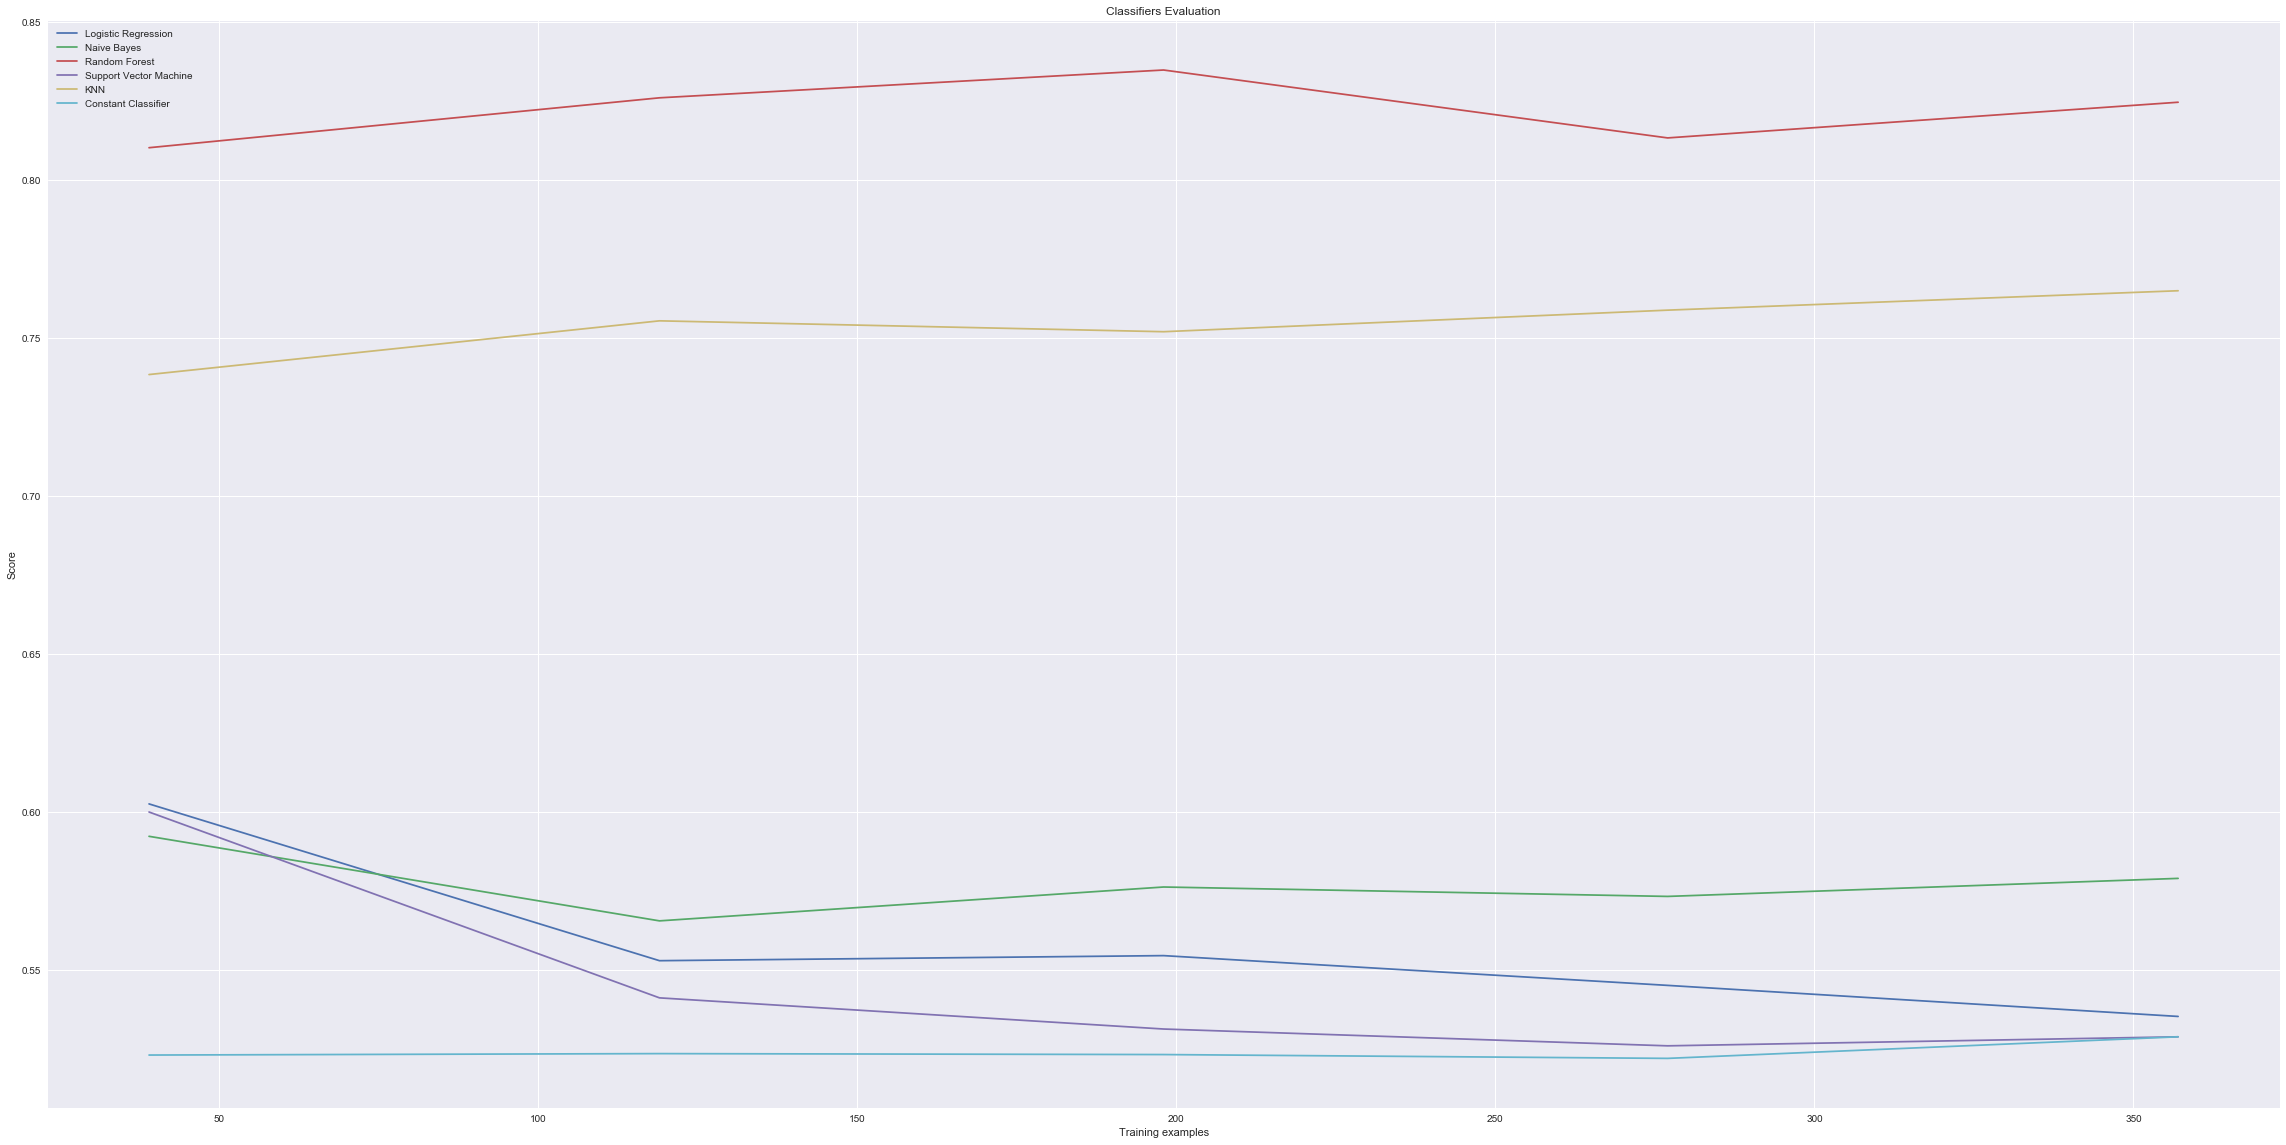

In [41]:
plt.figure(figsize=(40, 20))
plt.title('Classifiers Evaluation')
plt.xlabel('Training examples')
plt.ylabel('Score')

for clf, name in [(LogisticRegression(C=0.05, solver='lbfgs'), 'Logistic Regression'),
                  (BernoulliNB(), 'Naive Bayes'),
                  (RandomForestClassifier(n_estimators = 2, max_features = 2), 'Random Forest'),
                  (SVC(C = 0.01, kernel = 'linear'), 'Support Vector Machine'),
                  (KNeighborsClassifier(n_neighbors = 3), 'KNN'),
                  #(AdaBoostClassifier(), 'AdaBoost'),
                  #(QuadraticDiscriminantAnalysis(), 'Quadratic Discriminant'),
                  #(MLPClassifier(alpha=1), 'Multi-Layer Perceptron'),
                  #(DecisionTreeClassifier(max_depth=5), 'Decision Tree'),
                  (DummyClassifier(strategy = 'constant', constant = 1), 'Constant Classifier'),
                  #(GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True), 'Gaussian Process'),
                 ]:
    estimator = clf
    cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=0)
    train_sizes=np.linspace(0.1, 0.9, 5)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, Y, cv=cv, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.plot(train_sizes, train_scores_mean, label=name)
    
plt.legend(loc='best')
plt.savefig('classifiers.png', bbox_inches='tight')

plt.show()